## Preparing the dataset
Dataset is loaded under data/stanford.<br>
We use [Standord Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [1]:
# !wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O standford_background.tar.gz
# !tar xf standford_background.tar.gz

In [21]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3/deeplabv3_r50-d8_512x1024_40k_cityscapes/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth -P checkpoints

--2021-10-23 19:05:47--  https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3/deeplabv3_r50-d8_512x1024_40k_cityscapes/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272761181 (260M) [application/octet-stream]
Saving to: ‘checkpoints/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth’

deeplabv3_r50-d8_51 100%[===================>] 260.12M  9.12MB/s    in 33s     

2021-10-23 19:06:21 (7.78 MB/s) - ‘checkpoints/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth’ saved [272761181/272761181]



In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.6.0 True
0.18.0


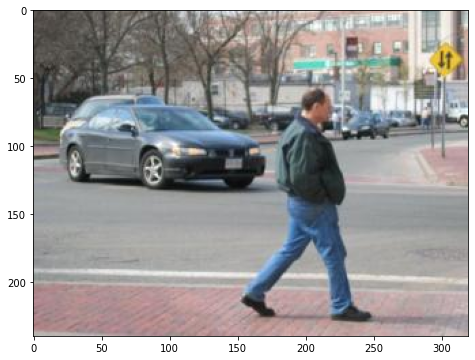

In [3]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

img = mmcv.imread('data/stanford/iccv09Data/images/6000124.jpg')
# img = mmcv.imread('../data/cityscapes/gtFine/test/bielefeld/bielefeld_000000_046495_gtFine_instanceIds.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [8]:

# convert dataset annotation to semantic segmentation map
data_root = 'data/stanford/iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

In [ ]:
           
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

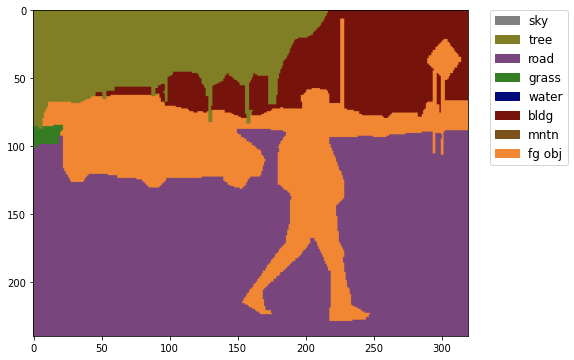

In [6]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('data/stanford/iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [7]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

In [30]:
from mmcv import Config

cfg = Config.fromfile('configs/deeplabv3/deeplabv3_r50-d8_256x256_1k_stanford.py')

In [27]:
from mmseg.apis import set_random_seed

#Freezing the backbone layers - lower layers 
norm_cfg = dict(type='BN', requires_grad=False)
cfg.model.backbone.norm_cfg = norm_cfg

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/test2'

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='ASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_inpu

In [28]:
torch.cuda.empty_cache()

In [29]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/lakswa/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/mmcv/utils/misc.py:334: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-10-23 19:19:17,916 - mmseg - INFO - Loaded 572 images
/home/lakswa/Project/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2021-10-23 19:19:19,035 - mmseg - INFO - Loaded 143 images
2021-10-23 19:19:19,036 - mmseg - INFO - load checkpoint from checkpoints/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth
2021-10-23 19:19:19,037 - mmseg - INFO - Use load_from_local loader
2021-10-23 19:19:19,230 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:23:15,764 - mmseg - INFO - per class results:
2021-10-23 19:23:15,765 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 83.03 | 90.23 |
|  tree  | 67.63 | 85.76 |
|  road  | 76.09 | 81.15 |
| grass  |  74.0 |  87.1 |
| water  | 42.21 | 42.86 |
|  bldg  | 48.56 | 52.05 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 41.36 | 88.34 |
+--------+-------+-------+
2021-10-23 19:23:15,766 - mmseg - INFO - Summary:
2021-10-23 19:23:15,767 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.91 | 54.11 | 65.94 |
+-------+-------+-------+
2021-10-23 19:23:15,768 - mmseg - INFO - Iter(val) [143]	aAcc: 0.7491, mIoU: 0.5411, mAcc: 0.6594, IoU.sky: 0.8303, IoU.tree: 0.6763, IoU.road: 0.7609, IoU.grass: 0.7400, IoU.water: 0.4221, IoU.bldg: 0.4856, IoU.mntn: 0.0000, IoU.fg obj: 0.4136, Acc.sky: 0.9023, Acc.tree: 0.8576, Acc.road: 0.8115, Acc.grass: 0.8710, Acc.water: 0.4286, Acc.bldg: 0.520

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:27:13,757 - mmseg - INFO - per class results:
2021-10-23 19:27:13,759 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 84.83 | 91.93 |
|  tree  |  68.8 | 87.34 |
|  road  | 86.32 | 93.44 |
| grass  | 78.97 | 89.58 |
| water  | 59.03 | 65.56 |
|  bldg  | 72.18 | 85.23 |
|  mntn  |  0.63 |  0.64 |
| fg obj | 62.05 | 74.69 |
+--------+-------+-------+
2021-10-23 19:27:13,759 - mmseg - INFO - Summary:
2021-10-23 19:27:13,760 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 84.97 | 64.1 | 73.55 |
+-------+------+-------+
2021-10-23 19:27:13,761 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8497, mIoU: 0.6410, mAcc: 0.7355, IoU.sky: 0.8483, IoU.tree: 0.6880, IoU.road: 0.8632, IoU.grass: 0.7897, IoU.water: 0.5903, IoU.bldg: 0.7218, IoU.mntn: 0.0063, IoU.fg obj: 0.6205, Acc.sky: 0.9193, Acc.tree: 0.8734, Acc.road: 0.9344, Acc.grass: 0.8958, Acc.water: 0.6556, Acc.bldg: 0.8523, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:31:11,866 - mmseg - INFO - per class results:
2021-10-23 19:31:11,868 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 83.87 | 93.77 |
|  tree  | 67.53 | 86.68 |
|  road  | 85.51 | 93.35 |
| grass  | 71.51 | 80.87 |
| water  |  60.4 |  80.3 |
|  bldg  | 69.94 | 76.19 |
|  mntn  |  0.77 |  0.78 |
| fg obj | 62.27 | 81.33 |
+--------+-------+-------+
2021-10-23 19:31:11,868 - mmseg - INFO - Summary:
2021-10-23 19:31:11,869 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.01 | 62.72 | 74.16 |
+-------+-------+-------+
2021-10-23 19:31:11,870 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8401, mIoU: 0.6272, mAcc: 0.7416, IoU.sky: 0.8387, IoU.tree: 0.6753, IoU.road: 0.8551, IoU.grass: 0.7151, IoU.water: 0.6040, IoU.bldg: 0.6994, IoU.mntn: 0.0077, IoU.fg obj: 0.6227, Acc.sky: 0.9377, Acc.tree: 0.8668, Acc.road: 0.9335, Acc.grass: 0.8087, Acc.water: 0.8030, Acc.bldg: 0.761

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:35:10,182 - mmseg - INFO - per class results:
2021-10-23 19:35:10,184 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 84.69 | 92.29 |
|  tree  | 63.12 | 93.65 |
|  road  | 87.52 | 92.24 |
| grass  | 66.42 | 76.11 |
| water  | 72.67 | 77.86 |
|  bldg  | 70.94 | 76.75 |
|  mntn  |  9.73 | 10.15 |
| fg obj |  65.7 | 80.14 |
+--------+-------+-------+
2021-10-23 19:35:10,184 - mmseg - INFO - Summary:
2021-10-23 19:35:10,185 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 84.41 | 65.1 | 74.9 |
+-------+------+------+
2021-10-23 19:35:10,186 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8441, mIoU: 0.6510, mAcc: 0.7490, IoU.sky: 0.8469, IoU.tree: 0.6312, IoU.road: 0.8752, IoU.grass: 0.6642, IoU.water: 0.7267, IoU.bldg: 0.7094, IoU.mntn: 0.0973, IoU.fg obj: 0.6570, Acc.sky: 0.9229, Acc.tree: 0.9365, Acc.road: 0.9224, Acc.grass: 0.7611, Acc.water: 0.7786, Acc.bldg: 0.7675, Acc.mnt

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:39:08,358 - mmseg - INFO - per class results:
2021-10-23 19:39:08,360 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 85.63 | 90.49 |
|  tree  | 71.16 | 87.01 |
|  road  | 87.15 | 92.32 |
| grass  | 76.73 | 92.63 |
| water  | 75.08 | 81.13 |
|  bldg  | 77.83 | 86.03 |
|  mntn  |  8.47 | 10.42 |
| fg obj | 65.84 | 83.74 |
+--------+-------+-------+
2021-10-23 19:39:08,360 - mmseg - INFO - Summary:
2021-10-23 19:39:08,361 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.76 | 68.49 | 77.97 |
+-------+-------+-------+
2021-10-23 19:39:08,362 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8676, mIoU: 0.6849, mAcc: 0.7797, IoU.sky: 0.8563, IoU.tree: 0.7116, IoU.road: 0.8715, IoU.grass: 0.7673, IoU.water: 0.7508, IoU.bldg: 0.7783, IoU.mntn: 0.0847, IoU.fg obj: 0.6584, Acc.sky: 0.9049, Acc.tree: 0.8701, Acc.road: 0.9232, Acc.grass: 0.9263, Acc.water: 0.8113, Acc.bldg: 0.860

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.8 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:43:06,801 - mmseg - INFO - per class results:
2021-10-23 19:43:06,802 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.52 | 92.11 |
|  tree  | 72.92 | 85.27 |
|  road  | 87.21 | 93.47 |
| grass  | 79.61 | 90.08 |
| water  | 69.89 |  88.8 |
|  bldg  | 76.68 | 84.97 |
|  mntn  | 26.02 | 34.76 |
| fg obj |  66.5 | 82.29 |
+--------+-------+-------+
2021-10-23 19:43:06,803 - mmseg - INFO - Summary:
2021-10-23 19:43:06,803 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.12 | 70.67 | 81.47 |
+-------+-------+-------+
2021-10-23 19:43:06,804 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8712, mIoU: 0.7067, mAcc: 0.8147, IoU.sky: 0.8652, IoU.tree: 0.7292, IoU.road: 0.8721, IoU.grass: 0.7961, IoU.water: 0.6989, IoU.bldg: 0.7668, IoU.mntn: 0.2602, IoU.fg obj: 0.6650, Acc.sky: 0.9211, Acc.tree: 0.8527, Acc.road: 0.9347, Acc.grass: 0.9008, Acc.water: 0.8880, Acc.bldg: 0.849

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:47:04,958 - mmseg - INFO - per class results:
2021-10-23 19:47:04,960 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.29 | 90.37 |
|  tree  | 73.06 | 86.48 |
|  road  | 89.78 | 93.71 |
| grass  |  79.7 | 89.37 |
| water  | 76.43 | 89.15 |
|  bldg  | 77.32 | 86.79 |
|  mntn  | 17.92 | 22.43 |
| fg obj | 67.17 | 84.86 |
+--------+-------+-------+
2021-10-23 19:47:04,960 - mmseg - INFO - Summary:
2021-10-23 19:47:04,961 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 87.65 | 70.96 | 80.4 |
+-------+-------+------+
2021-10-23 19:47:04,962 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8765, mIoU: 0.7096, mAcc: 0.8040, IoU.sky: 0.8629, IoU.tree: 0.7306, IoU.road: 0.8978, IoU.grass: 0.7970, IoU.water: 0.7643, IoU.bldg: 0.7732, IoU.mntn: 0.1792, IoU.fg obj: 0.6717, Acc.sky: 0.9037, Acc.tree: 0.8648, Acc.road: 0.9371, Acc.grass: 0.8937, Acc.water: 0.8915, Acc.bldg: 0.8679, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:51:03,119 - mmseg - INFO - per class results:
2021-10-23 19:51:03,120 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.07 | 93.25 |
|  tree  | 73.13 | 88.27 |
|  road  | 90.05 | 94.95 |
| grass  | 79.03 | 89.49 |
| water  | 80.27 | 85.08 |
|  bldg  | 78.39 | 88.48 |
|  mntn  | 30.45 | 38.45 |
| fg obj | 69.66 | 79.96 |
+--------+-------+-------+
2021-10-23 19:51:03,121 - mmseg - INFO - Summary:
2021-10-23 19:51:03,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.48 | 73.51 | 82.24 |
+-------+-------+-------+
2021-10-23 19:51:03,123 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8848, mIoU: 0.7351, mAcc: 0.8224, IoU.sky: 0.8707, IoU.tree: 0.7313, IoU.road: 0.9005, IoU.grass: 0.7903, IoU.water: 0.8027, IoU.bldg: 0.7839, IoU.mntn: 0.3045, IoU.fg obj: 0.6966, Acc.sky: 0.9325, Acc.tree: 0.8827, Acc.road: 0.9495, Acc.grass: 0.8949, Acc.water: 0.8508, Acc.bldg: 0.884

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:55:01,388 - mmseg - INFO - per class results:
2021-10-23 19:55:01,389 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.91 | 93.79 |
|  tree  | 73.64 | 85.67 |
|  road  | 90.18 | 94.48 |
| grass  | 80.16 | 89.15 |
| water  |  82.0 | 89.31 |
|  bldg  | 78.36 | 90.48 |
|  mntn  | 30.09 | 38.81 |
| fg obj | 70.38 | 80.59 |
+--------+-------+-------+
2021-10-23 19:55:01,390 - mmseg - INFO - Summary:
2021-10-23 19:55:01,390 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.74 | 74.09 | 82.78 |
+-------+-------+-------+
2021-10-23 19:55:01,392 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8874, mIoU: 0.7409, mAcc: 0.8278, IoU.sky: 0.8791, IoU.tree: 0.7364, IoU.road: 0.9018, IoU.grass: 0.8016, IoU.water: 0.8200, IoU.bldg: 0.7836, IoU.mntn: 0.3009, IoU.fg obj: 0.7038, Acc.sky: 0.9379, Acc.tree: 0.8567, Acc.road: 0.9448, Acc.grass: 0.8915, Acc.water: 0.8931, Acc.bldg: 0.904

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 19:59:00,756 - mmseg - INFO - per class results:
2021-10-23 19:59:00,758 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   |  88.2 |  93.7 |
|  tree  | 73.85 | 86.32 |
|  road  | 90.22 | 94.59 |
| grass  | 79.91 | 89.36 |
| water  | 82.84 | 87.71 |
|  bldg  | 79.09 | 88.72 |
|  mntn  | 37.22 | 50.21 |
| fg obj | 70.79 | 83.33 |
+--------+-------+-------+
2021-10-23 19:59:00,759 - mmseg - INFO - Summary:
2021-10-23 19:59:00,759 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.99 | 75.26 | 84.24 |
+-------+-------+-------+
2021-10-23 19:59:00,760 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8899, mIoU: 0.7526, mAcc: 0.8424, IoU.sky: 0.8820, IoU.tree: 0.7385, IoU.road: 0.9022, IoU.grass: 0.7991, IoU.water: 0.8284, IoU.bldg: 0.7909, IoU.mntn: 0.3722, IoU.fg obj: 0.7079, Acc.sky: 0.9370, Acc.tree: 0.8632, Acc.road: 0.9459, Acc.grass: 0.8936, Acc.water: 0.8771, Acc.bldg: 0.887

## Fine tuning above layers

In [31]:
cfg = Config.fromfile('configs/deeplabv3/deeplabv3_r50-d8_256x256_1k_stanford.py')

In [32]:
#Freezing the backbone layers - lower layers 
norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = norm_cfg

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'work_dirs/test2/iter_1000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/test2/fine_tuned'

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='ASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input

Training and Evaluating by using the checkpoint from previous training with frozen layers. Here, we are training for all the layers.

In [33]:
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/lakswa/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/mmcv/utils/misc.py:334: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-10-23 20:17:54,316 - mmseg - INFO - Loaded 572 images
/home/lakswa/Project/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2021-10-23 20:17:55,436 - mmseg - INFO - Loaded 143 images
2021-10-23 20:17:55,437 - mmseg - INFO - load checkpoint from work_dirs/test2/iter_1000.pth
2021-10-23 20:17:55,437 - mmseg - INFO - Use load_from_local loader
2021-10-23 20:17:55,750 - mmseg - INFO - Start running, host: lakswa@dml-instance, work_dir: /home/lakswa/Project/mmsegmentation/work_dirs/test2/fine_tuned
2021-10-23 20:17:55,752 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:21:54,036 - mmseg - INFO - per class results:
2021-10-23 20:21:54,038 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 83.81 | 93.86 |
|  tree  | 68.23 | 81.94 |
|  road  | 87.39 | 92.14 |
| grass  | 76.25 | 91.89 |
| water  | 77.21 |  85.5 |
|  bldg  | 73.48 | 84.65 |
|  mntn  |  4.07 |  4.65 |
| fg obj | 61.47 | 78.04 |
+--------+-------+-------+
2021-10-23 20:21:54,039 - mmseg - INFO - Summary:
2021-10-23 20:21:54,039 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.32 | 66.49 | 76.58 |
+-------+-------+-------+
2021-10-23 20:21:54,040 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8532, mIoU: 0.6649, mAcc: 0.7658, IoU.sky: 0.8381, IoU.tree: 0.6823, IoU.road: 0.8739, IoU.grass: 0.7625, IoU.water: 0.7721, IoU.bldg: 0.7348, IoU.mntn: 0.0407, IoU.fg obj: 0.6147, Acc.sky: 0.9386, Acc.tree: 0.8194, Acc.road: 0.9214, Acc.grass: 0.9189, Acc.water: 0.8550, Acc.bldg: 0.846

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:25:54,340 - mmseg - INFO - per class results:
2021-10-23 20:25:54,342 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.36 | 92.29 |
|  tree  | 69.92 | 81.22 |
|  road  | 87.97 | 93.28 |
| grass  | 75.33 | 93.17 |
| water  | 77.13 |  80.5 |
|  bldg  |  75.6 | 90.94 |
|  mntn  | 33.45 | 46.33 |
| fg obj | 66.74 | 75.68 |
+--------+-------+-------+
2021-10-23 20:25:54,342 - mmseg - INFO - Summary:
2021-10-23 20:25:54,343 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.03 | 71.69 | 81.68 |
+-------+-------+-------+
2021-10-23 20:25:54,344 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8703, mIoU: 0.7169, mAcc: 0.8168, IoU.sky: 0.8736, IoU.tree: 0.6992, IoU.road: 0.8797, IoU.grass: 0.7533, IoU.water: 0.7713, IoU.bldg: 0.7560, IoU.mntn: 0.3345, IoU.fg obj: 0.6674, Acc.sky: 0.9229, Acc.tree: 0.8122, Acc.road: 0.9328, Acc.grass: 0.9317, Acc.water: 0.8050, Acc.bldg: 0.909

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:29:54,727 - mmseg - INFO - per class results:
2021-10-23 20:29:54,729 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.63 | 92.97 |
|  tree  | 70.53 | 84.98 |
|  road  | 88.51 | 95.12 |
| grass  | 82.39 | 91.27 |
| water  | 76.51 | 79.05 |
|  bldg  | 77.46 | 87.68 |
|  mntn  |  36.9 | 45.37 |
| fg obj | 67.84 | 79.87 |
+--------+-------+-------+
2021-10-23 20:29:54,730 - mmseg - INFO - Summary:
2021-10-23 20:29:54,730 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.79 | 73.35 | 82.04 |
+-------+-------+-------+
2021-10-23 20:29:54,731 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8779, mIoU: 0.7335, mAcc: 0.8204, IoU.sky: 0.8663, IoU.tree: 0.7053, IoU.road: 0.8851, IoU.grass: 0.8239, IoU.water: 0.7651, IoU.bldg: 0.7746, IoU.mntn: 0.3690, IoU.fg obj: 0.6784, Acc.sky: 0.9297, Acc.tree: 0.8498, Acc.road: 0.9512, Acc.grass: 0.9127, Acc.water: 0.7905, Acc.bldg: 0.876

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:33:55,161 - mmseg - INFO - per class results:
2021-10-23 20:33:55,162 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.39 | 93.28 |
|  tree  | 72.25 | 87.28 |
|  road  | 89.37 | 94.01 |
| grass  | 79.67 |  91.8 |
| water  | 77.12 | 83.27 |
|  bldg  | 79.06 | 86.88 |
|  mntn  | 47.14 | 64.94 |
| fg obj | 70.75 | 82.58 |
+--------+-------+-------+
2021-10-23 20:33:55,164 - mmseg - INFO - Summary:
2021-10-23 20:33:55,164 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 88.63 | 75.35 | 85.5 |
+-------+-------+------+
2021-10-23 20:33:55,165 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8863, mIoU: 0.7535, mAcc: 0.8550, IoU.sky: 0.8739, IoU.tree: 0.7225, IoU.road: 0.8937, IoU.grass: 0.7967, IoU.water: 0.7712, IoU.bldg: 0.7906, IoU.mntn: 0.4714, IoU.fg obj: 0.7075, Acc.sky: 0.9328, Acc.tree: 0.8728, Acc.road: 0.9401, Acc.grass: 0.9180, Acc.water: 0.8327, Acc.bldg: 0.8688, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:37:55,534 - mmseg - INFO - per class results:
2021-10-23 20:37:55,536 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.77 | 92.39 |
|  tree  | 72.48 | 89.66 |
|  road  |  89.6 | 95.08 |
| grass  | 80.58 | 89.95 |
| water  | 81.67 | 87.97 |
|  bldg  | 77.52 |  84.6 |
|  mntn  | 33.39 | 38.75 |
| fg obj | 69.84 | 84.16 |
+--------+-------+-------+
2021-10-23 20:37:55,536 - mmseg - INFO - Summary:
2021-10-23 20:37:55,537 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.41 | 74.11 | 82.82 |
+-------+-------+-------+
2021-10-23 20:37:55,538 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8841, mIoU: 0.7411, mAcc: 0.8282, IoU.sky: 0.8777, IoU.tree: 0.7248, IoU.road: 0.8960, IoU.grass: 0.8058, IoU.water: 0.8167, IoU.bldg: 0.7752, IoU.mntn: 0.3339, IoU.fg obj: 0.6984, Acc.sky: 0.9239, Acc.tree: 0.8966, Acc.road: 0.9508, Acc.grass: 0.8995, Acc.water: 0.8797, Acc.bldg: 0.846

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:41:55,850 - mmseg - INFO - per class results:
2021-10-23 20:41:55,851 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.85 | 92.58 |
|  tree  | 72.94 |  86.8 |
|  road  | 89.32 | 95.01 |
| grass  | 80.51 | 92.71 |
| water  | 81.79 | 88.61 |
|  bldg  | 78.79 |  88.1 |
|  mntn  | 28.69 | 35.91 |
| fg obj | 71.12 | 82.55 |
+--------+-------+-------+
2021-10-23 20:41:55,852 - mmseg - INFO - Summary:
2021-10-23 20:41:55,853 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.68 | 73.88 | 82.78 |
+-------+-------+-------+
2021-10-23 20:41:55,854 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8868, mIoU: 0.7388, mAcc: 0.8278, IoU.sky: 0.8785, IoU.tree: 0.7294, IoU.road: 0.8932, IoU.grass: 0.8051, IoU.water: 0.8179, IoU.bldg: 0.7879, IoU.mntn: 0.2869, IoU.fg obj: 0.7112, Acc.sky: 0.9258, Acc.tree: 0.8680, Acc.road: 0.9501, Acc.grass: 0.9271, Acc.water: 0.8861, Acc.bldg: 0.881

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:45:56,344 - mmseg - INFO - per class results:
2021-10-23 20:45:56,346 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.65 |  91.7 |
|  tree  | 73.31 | 87.11 |
|  road  | 90.64 | 94.73 |
| grass  | 81.79 | 90.12 |
| water  | 82.45 | 91.22 |
|  bldg  | 79.01 | 89.01 |
|  mntn  | 34.93 | 44.28 |
| fg obj | 70.97 | 83.43 |
+--------+-------+-------+
2021-10-23 20:45:56,346 - mmseg - INFO - Summary:
2021-10-23 20:45:56,347 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.98 | 75.09 | 83.95 |
+-------+-------+-------+
2021-10-23 20:45:56,348 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8898, mIoU: 0.7509, mAcc: 0.8395, IoU.sky: 0.8765, IoU.tree: 0.7331, IoU.road: 0.9064, IoU.grass: 0.8179, IoU.water: 0.8245, IoU.bldg: 0.7901, IoU.mntn: 0.3493, IoU.fg obj: 0.7097, Acc.sky: 0.9170, Acc.tree: 0.8711, Acc.road: 0.9473, Acc.grass: 0.9012, Acc.water: 0.9122, Acc.bldg: 0.890

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:49:56,860 - mmseg - INFO - per class results:
2021-10-23 20:49:56,861 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.02 | 94.01 |
|  tree  | 73.15 | 87.22 |
|  road  | 90.76 | 95.42 |
| grass  | 81.93 | 91.04 |
| water  | 84.19 | 90.06 |
|  bldg  | 79.36 | 88.61 |
|  mntn  | 30.95 | 39.16 |
| fg obj | 70.85 | 81.76 |
+--------+-------+-------+
2021-10-23 20:49:56,862 - mmseg - INFO - Summary:
2021-10-23 20:49:56,863 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.08 | 74.9 | 83.41 |
+-------+------+-------+
2021-10-23 20:49:56,864 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8908, mIoU: 0.7490, mAcc: 0.8341, IoU.sky: 0.8802, IoU.tree: 0.7315, IoU.road: 0.9076, IoU.grass: 0.8193, IoU.water: 0.8419, IoU.bldg: 0.7936, IoU.mntn: 0.3095, IoU.fg obj: 0.7085, Acc.sky: 0.9401, Acc.tree: 0.8722, Acc.road: 0.9542, Acc.grass: 0.9104, Acc.water: 0.9006, Acc.bldg: 0.8861, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:53:57,337 - mmseg - INFO - per class results:
2021-10-23 20:53:57,339 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.18 | 93.78 |
|  tree  | 73.36 | 85.54 |
|  road  | 90.66 | 94.66 |
| grass  | 82.84 | 89.72 |
| water  | 83.48 | 90.69 |
|  bldg  | 79.53 | 90.43 |
|  mntn  | 34.95 | 46.51 |
| fg obj | 71.82 | 82.61 |
+--------+-------+-------+
2021-10-23 20:53:57,339 - mmseg - INFO - Summary:
2021-10-23 20:53:57,340 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.25 | 75.6 | 84.24 |
+-------+------+-------+
2021-10-23 20:53:57,341 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8925, mIoU: 0.7560, mAcc: 0.8424, IoU.sky: 0.8818, IoU.tree: 0.7336, IoU.road: 0.9066, IoU.grass: 0.8284, IoU.water: 0.8348, IoU.bldg: 0.7953, IoU.mntn: 0.3495, IoU.fg obj: 0.7182, Acc.sky: 0.9378, Acc.tree: 0.8554, Acc.road: 0.9466, Acc.grass: 0.8972, Acc.water: 0.9069, Acc.bldg: 0.9043, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 7.9 task/s, elapsed: 18s, ETA:     0s

2021-10-23 20:57:59,042 - mmseg - INFO - per class results:
2021-10-23 20:57:59,043 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.32 | 93.56 |
|  tree  | 73.67 | 86.83 |
|  road  | 90.34 | 94.81 |
| grass  | 80.84 | 90.69 |
| water  | 83.34 | 89.68 |
|  bldg  | 79.89 | 88.84 |
|  mntn  | 36.45 | 49.08 |
| fg obj | 71.78 | 83.37 |
+--------+-------+-------+
2021-10-23 20:57:59,044 - mmseg - INFO - Summary:
2021-10-23 20:57:59,045 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.24 | 75.58 | 84.61 |
+-------+-------+-------+
2021-10-23 20:57:59,046 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8924, mIoU: 0.7558, mAcc: 0.8461, IoU.sky: 0.8832, IoU.tree: 0.7367, IoU.road: 0.9034, IoU.grass: 0.8084, IoU.water: 0.8334, IoU.bldg: 0.7989, IoU.mntn: 0.3645, IoU.fg obj: 0.7178, Acc.sky: 0.9356, Acc.tree: 0.8683, Acc.road: 0.9481, Acc.grass: 0.9069, Acc.water: 0.8968, Acc.bldg: 0.888

/home/lakswa/Project/mmsegmentation/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

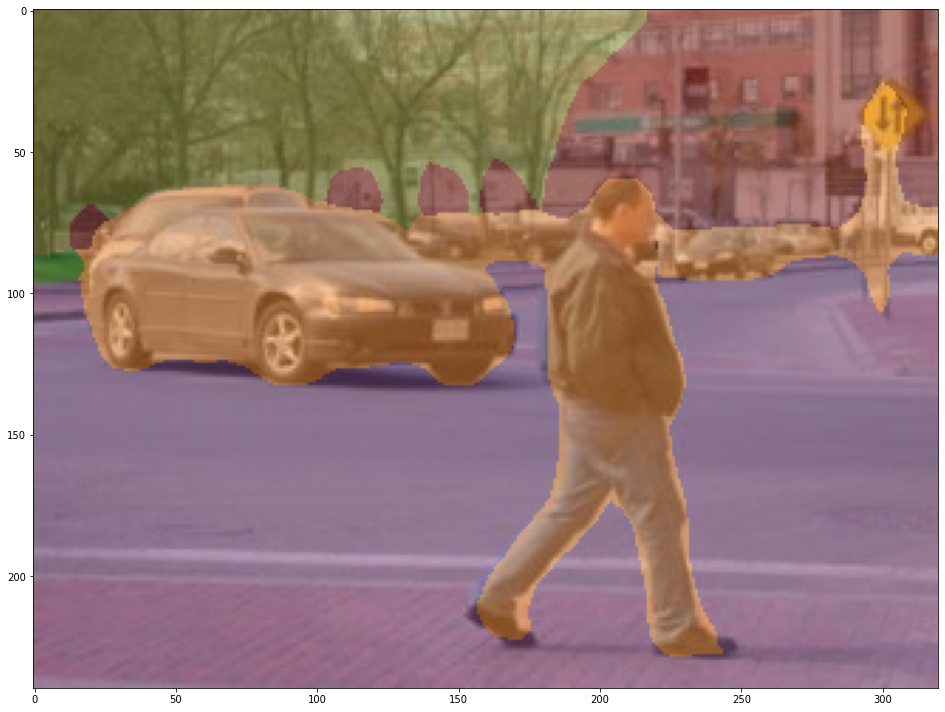

In [34]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
# from mmseg.core.evaluation import get_palette

img = mmcv.imread('data/stanford/iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

<Figure size 576x432 with 0 Axes>

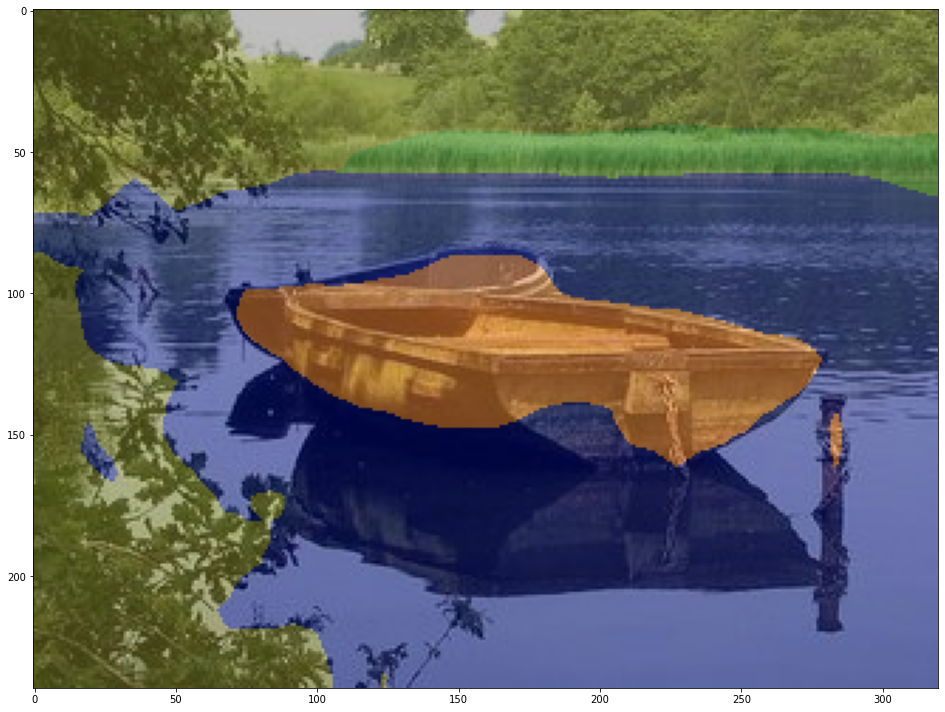

In [36]:

img = mmcv.imread('data/stanford/iccv09Data/images/2000032.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

<Figure size 576x432 with 0 Axes>

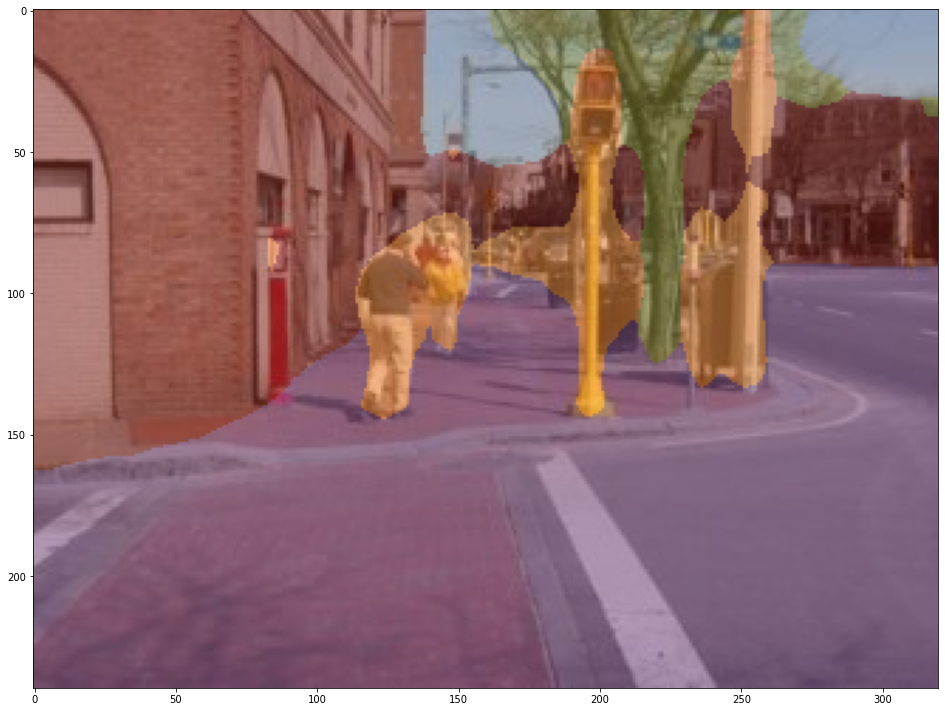

In [38]:

img = mmcv.imread('data/stanford/iccv09Data/images/6000132.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

### FCN model

In [40]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/hrnet/fcn_hr18_512x1024_40k_cityscapes/fcn_hr18_512x1024_40k_cityscapes_20200601_014216-f196fb4e.pth -P checkpoints/

--2021-10-23 21:15:57--  https://download.openmmlab.com/mmsegmentation/v0.5/hrnet/fcn_hr18_512x1024_40k_cityscapes/fcn_hr18_512x1024_40k_cityscapes_20200601_014216-f196fb4e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39026764 (37M) [application/octet-stream]
Saving to: ‘checkpoints/fcn_hr18_512x1024_40k_cityscapes_20200601_014216-f196fb4e.pth’

fcn_hr18_512x1024_4 100%[===================>]  37.22M  6.39MB/s    in 6.2s    

2021-10-23 21:16:04 (5.96 MB/s) - ‘checkpoints/fcn_hr18_512x1024_40k_cityscapes_20200601_014216-f196fb4e.pth’ saved [39026764/39026764]



In [41]:
cfg = Config.fromfile('configs/fcn/fcn_hr18_256x256_1k_stanford.py')

In [42]:
from mmseg.apis import set_random_seed

#Freezing the backbone layers - lower layers 
norm_cfg = dict(type='BN', requires_grad=False)
cfg.model.backbone.norm_cfg = norm_cfg

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/fcn_hr18_512x1024_40k_cityscapes_20200601_014216-f196fb4e.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/fcn'

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://msra/hrnetv2_w18',
    backbone=dict(
        type='HRNet',
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=False,
        extra=dict(
            stage1=dict(
                num_modules=1,
                num_branches=1,
                block='BOTTLENECK',
                num_blocks=(4, ),
                num_channels=(64, )),
            stage2=dict(
                num_modules=1,
                num_branches=2,
                block='BASIC',
                num_blocks=(4, 4),
                num_channels=(18, 36)),
            stage3=dict(
                num_modules=4,
                num_branches=3,
                block='BASIC',
                num_blocks=(4, 4, 4),
                num_channels=(18, 36, 72)),
            stage4=dict(
                num_modules=3,
                num_branches=4,
                block='BASIC',
     

In [43]:
torch.cuda.empty_cache()

In [44]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/lakswa/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/mmcv/utils/misc.py:334: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-10-23 21:31:39,075 - mmseg - INFO - Loaded 572 images
/home/lakswa/Project/mmsegmentation/mmseg/models/backbones/hrnet.py:318: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2021-10-23 21:31:39,343 - mmseg - INFO - Loaded 143 images
2021-10-23 21:31:39,344 - mmseg - INFO - load checkpoint from checkpoints/fcn_hr18_512x1024_40k_cityscapes_20200601_014216-f196fb4e.pth
2021-10-23 21:31:39,345 - mmseg - INFO - Use load_from_local loader
2021-10-23 21:31:39,854 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 270, 1, 1]) from checkpoint, the shape i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:33:34,649 - mmseg - INFO - per class results:
2021-10-23 21:33:34,650 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 84.33 | 91.23 |
|  tree  | 62.61 | 71.99 |
|  road  | 83.39 | 87.78 |
| grass  | 61.11 | 76.24 |
| water  | 60.89 | 78.97 |
|  bldg  | 67.68 | 93.19 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 60.85 | 70.75 |
+--------+-------+-------+
2021-10-23 21:33:34,651 - mmseg - INFO - Summary:
2021-10-23 21:33:34,651 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.33 | 60.11 | 71.27 |
+-------+-------+-------+
2021-10-23 21:33:34,652 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8233, mIoU: 0.6011, mAcc: 0.7127, IoU.sky: 0.8433, IoU.tree: 0.6261, IoU.road: 0.8339, IoU.grass: 0.6111, IoU.water: 0.6089, IoU.bldg: 0.6768, IoU.mntn: 0.0000, IoU.fg obj: 0.6085, Acc.sky: 0.9123, Acc.tree: 0.7199, Acc.road: 0.8778, Acc.grass: 0.7624, Acc.water: 0.7897, Acc.bldg: 0.931

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:35:30,713 - mmseg - INFO - per class results:
2021-10-23 21:35:30,714 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.19 | 92.23 |
|  tree  | 68.96 | 88.64 |
|  road  | 85.17 | 92.68 |
| grass  | 75.45 | 91.35 |
| water  | 59.77 | 79.02 |
|  bldg  | 73.15 | 86.52 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 61.55 | 68.32 |
+--------+-------+-------+
2021-10-23 21:35:30,715 - mmseg - INFO - Summary:
2021-10-23 21:35:30,716 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.97 | 63.78 | 74.85 |
+-------+-------+-------+
2021-10-23 21:35:30,717 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8497, mIoU: 0.6378, mAcc: 0.7485, IoU.sky: 0.8619, IoU.tree: 0.6896, IoU.road: 0.8517, IoU.grass: 0.7545, IoU.water: 0.5977, IoU.bldg: 0.7315, IoU.mntn: 0.0000, IoU.fg obj: 0.6155, Acc.sky: 0.9223, Acc.tree: 0.8864, Acc.road: 0.9268, Acc.grass: 0.9135, Acc.water: 0.7902, Acc.bldg: 0.865

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:37:27,467 - mmseg - INFO - per class results:
2021-10-23 21:37:27,469 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   |  86.0 |  92.5 |
|  tree  | 70.12 | 77.64 |
|  road  | 84.16 |  95.4 |
| grass  | 77.04 | 89.99 |
| water  | 58.01 | 62.83 |
|  bldg  | 73.28 | 91.98 |
|  mntn  |  0.17 |  0.17 |
| fg obj | 62.88 | 72.52 |
+--------+-------+-------+
2021-10-23 21:37:27,470 - mmseg - INFO - Summary:
2021-10-23 21:37:27,470 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.23 | 63.96 | 72.88 |
+-------+-------+-------+
2021-10-23 21:37:27,471 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8523, mIoU: 0.6396, mAcc: 0.7288, IoU.sky: 0.8600, IoU.tree: 0.7012, IoU.road: 0.8416, IoU.grass: 0.7704, IoU.water: 0.5801, IoU.bldg: 0.7328, IoU.mntn: 0.0017, IoU.fg obj: 0.6288, Acc.sky: 0.9250, Acc.tree: 0.7764, Acc.road: 0.9540, Acc.grass: 0.8999, Acc.water: 0.6283, Acc.bldg: 0.919

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.3 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:39:23,872 - mmseg - INFO - per class results:
2021-10-23 21:39:23,876 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.33 | 92.24 |
|  tree  | 72.27 | 87.09 |
|  road  | 87.32 | 93.01 |
| grass  | 77.04 | 86.34 |
| water  | 68.99 | 88.09 |
|  bldg  | 76.09 |  85.9 |
|  mntn  |  0.03 |  0.03 |
| fg obj | 65.93 | 82.64 |
+--------+-------+-------+
2021-10-23 21:39:23,876 - mmseg - INFO - Summary:
2021-10-23 21:39:23,877 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.74 | 66.88 | 76.92 |
+-------+-------+-------+
2021-10-23 21:39:23,878 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8674, mIoU: 0.6688, mAcc: 0.7692, IoU.sky: 0.8733, IoU.tree: 0.7227, IoU.road: 0.8732, IoU.grass: 0.7704, IoU.water: 0.6899, IoU.bldg: 0.7609, IoU.mntn: 0.0003, IoU.fg obj: 0.6593, Acc.sky: 0.9224, Acc.tree: 0.8709, Acc.road: 0.9301, Acc.grass: 0.8634, Acc.water: 0.8809, Acc.bldg: 0.859

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:41:20,462 - mmseg - INFO - per class results:
2021-10-23 21:41:20,463 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.78 | 94.08 |
|  tree  | 70.65 |  83.5 |
|  road  | 86.62 | 92.89 |
| grass  | 74.39 | 93.14 |
| water  |  74.6 | 83.96 |
|  bldg  | 75.38 | 85.91 |
|  mntn  |  9.46 | 11.35 |
| fg obj | 66.76 |  80.4 |
+--------+-------+-------+
2021-10-23 21:41:20,464 - mmseg - INFO - Summary:
2021-10-23 21:41:20,464 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.52 | 68.08 | 78.15 |
+-------+-------+-------+
2021-10-23 21:41:20,466 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8652, mIoU: 0.6808, mAcc: 0.7815, IoU.sky: 0.8678, IoU.tree: 0.7065, IoU.road: 0.8662, IoU.grass: 0.7439, IoU.water: 0.7460, IoU.bldg: 0.7538, IoU.mntn: 0.0946, IoU.fg obj: 0.6676, Acc.sky: 0.9408, Acc.tree: 0.8350, Acc.road: 0.9289, Acc.grass: 0.9314, Acc.water: 0.8396, Acc.bldg: 0.859

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:43:17,027 - mmseg - INFO - per class results:
2021-10-23 21:43:17,028 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   |  87.6 |  93.8 |
|  tree  | 71.19 | 79.23 |
|  road  | 88.07 | 94.07 |
| grass  | 77.72 | 94.19 |
| water  | 74.58 | 89.34 |
|  bldg  | 77.29 | 88.77 |
|  mntn  |  9.23 |  11.9 |
| fg obj | 68.49 |  82.8 |
+--------+-------+-------+
2021-10-23 21:43:17,029 - mmseg - INFO - Summary:
2021-10-23 21:43:17,029 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.36 | 69.27 | 79.27 |
+-------+-------+-------+
2021-10-23 21:43:17,030 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8736, mIoU: 0.6927, mAcc: 0.7927, IoU.sky: 0.8760, IoU.tree: 0.7119, IoU.road: 0.8807, IoU.grass: 0.7772, IoU.water: 0.7458, IoU.bldg: 0.7729, IoU.mntn: 0.0923, IoU.fg obj: 0.6849, Acc.sky: 0.9380, Acc.tree: 0.7923, Acc.road: 0.9407, Acc.grass: 0.9419, Acc.water: 0.8934, Acc.bldg: 0.887

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:45:13,446 - mmseg - INFO - per class results:
2021-10-23 21:45:13,448 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.43 | 93.79 |
|  tree  | 72.69 | 83.46 |
|  road  |  88.6 | 95.87 |
| grass  | 81.46 | 89.78 |
| water  |  74.8 | 89.58 |
|  bldg  | 77.17 | 86.66 |
|  mntn  | 15.99 | 20.42 |
| fg obj | 67.92 | 81.73 |
+--------+-------+-------+
2021-10-23 21:45:13,448 - mmseg - INFO - Summary:
2021-10-23 21:45:13,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.71 | 70.76 | 80.16 |
+-------+-------+-------+
2021-10-23 21:45:13,450 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8771, mIoU: 0.7076, mAcc: 0.8016, IoU.sky: 0.8743, IoU.tree: 0.7269, IoU.road: 0.8860, IoU.grass: 0.8146, IoU.water: 0.7480, IoU.bldg: 0.7717, IoU.mntn: 0.1599, IoU.fg obj: 0.6792, Acc.sky: 0.9379, Acc.tree: 0.8346, Acc.road: 0.9587, Acc.grass: 0.8978, Acc.water: 0.8958, Acc.bldg: 0.866

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:47:10,140 - mmseg - INFO - per class results:
2021-10-23 21:47:10,142 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.54 | 92.48 |
|  tree  | 72.07 |  87.3 |
|  road  | 88.25 | 94.08 |
| grass  | 81.98 | 92.16 |
| water  | 73.72 | 91.51 |
|  bldg  | 78.32 | 85.77 |
|  mntn  | 15.08 | 18.53 |
| fg obj | 69.15 | 83.21 |
+--------+-------+-------+
2021-10-23 21:47:10,142 - mmseg - INFO - Summary:
2021-10-23 21:47:10,143 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.84 | 70.76 | 80.63 |
+-------+-------+-------+
2021-10-23 21:47:10,144 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8784, mIoU: 0.7076, mAcc: 0.8063, IoU.sky: 0.8754, IoU.tree: 0.7207, IoU.road: 0.8825, IoU.grass: 0.8198, IoU.water: 0.7372, IoU.bldg: 0.7832, IoU.mntn: 0.1508, IoU.fg obj: 0.6915, Acc.sky: 0.9248, Acc.tree: 0.8730, Acc.road: 0.9408, Acc.grass: 0.9216, Acc.water: 0.9151, Acc.bldg: 0.857

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:49:06,428 - mmseg - INFO - per class results:
2021-10-23 21:49:06,430 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.96 | 93.82 |
|  tree  | 73.27 | 85.75 |
|  road  | 88.46 | 94.61 |
| grass  |  82.2 | 90.85 |
| water  | 74.63 | 91.41 |
|  bldg  | 78.77 | 88.24 |
|  mntn  | 23.24 | 29.45 |
| fg obj | 69.48 | 80.85 |
+--------+-------+-------+
2021-10-23 21:49:06,430 - mmseg - INFO - Summary:
2021-10-23 21:49:06,431 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.29 | 72.25 | 81.87 |
+-------+-------+-------+
2021-10-23 21:49:06,432 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8829, mIoU: 0.7225, mAcc: 0.8187, IoU.sky: 0.8796, IoU.tree: 0.7327, IoU.road: 0.8846, IoU.grass: 0.8220, IoU.water: 0.7463, IoU.bldg: 0.7877, IoU.mntn: 0.2324, IoU.fg obj: 0.6948, Acc.sky: 0.9382, Acc.tree: 0.8575, Acc.road: 0.9461, Acc.grass: 0.9085, Acc.water: 0.9141, Acc.bldg: 0.882

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 21:51:03,383 - mmseg - INFO - per class results:
2021-10-23 21:51:03,385 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.26 | 92.79 |
|  tree  | 73.62 | 85.94 |
|  road  | 89.32 | 95.64 |
| grass  | 81.22 | 91.91 |
| water  | 80.43 | 91.04 |
|  bldg  | 79.08 | 87.95 |
|  mntn  | 23.62 | 29.49 |
| fg obj | 70.05 | 82.83 |
+--------+-------+-------+
2021-10-23 21:51:03,385 - mmseg - INFO - Summary:
2021-10-23 21:51:03,386 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 88.66 | 73.2 | 82.2 |
+-------+------+------+
2021-10-23 21:51:03,388 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8866, mIoU: 0.7320, mAcc: 0.8220, IoU.sky: 0.8826, IoU.tree: 0.7362, IoU.road: 0.8932, IoU.grass: 0.8122, IoU.water: 0.8043, IoU.bldg: 0.7908, IoU.mntn: 0.2362, IoU.fg obj: 0.7005, Acc.sky: 0.9279, Acc.tree: 0.8594, Acc.road: 0.9564, Acc.grass: 0.9191, Acc.water: 0.9104, Acc.bldg: 0.8795, Acc.mnt

### Fine Tuning 

In [46]:
cfg = Config.fromfile('configs/fcn/fcn_hr18_256x256_1k_stanford.py')

In [47]:
from mmseg.apis import set_random_seed
 
norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = norm_cfg

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'work_dirs/fcn/iter_1000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/fcn/fine_tuned'

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://msra/hrnetv2_w18',
    backbone=dict(
        type='HRNet',
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        extra=dict(
            stage1=dict(
                num_modules=1,
                num_branches=1,
                block='BOTTLENECK',
                num_blocks=(4, ),
                num_channels=(64, )),
            stage2=dict(
                num_modules=1,
                num_branches=2,
                block='BASIC',
                num_blocks=(4, 4),
                num_channels=(18, 36)),
            stage3=dict(
                num_modules=4,
                num_branches=3,
                block='BASIC',
                num_blocks=(4, 4, 4),
                num_channels=(18, 36, 72)),
            stage4=dict(
                num_modules=3,
                num_branches=4,
                block='BASIC',
      

In [48]:
torch.cuda.empty_cache()

In [49]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/home/lakswa/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/mmcv/utils/misc.py:334: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-10-23 22:01:13,070 - mmseg - INFO - Loaded 572 images
/home/lakswa/Project/mmsegmentation/mmseg/models/backbones/hrnet.py:318: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2021-10-23 22:01:13,338 - mmseg - INFO - Loaded 143 images
2021-10-23 22:01:13,339 - mmseg - INFO - load checkpoint from work_dirs/fcn/iter_1000.pth
2021-10-23 22:01:13,339 - mmseg - INFO - Use load_from_local loader
2021-10-23 22:01:13,811 - mmseg - INFO - Start running, host: lakswa@dml-instance, work_dir: /home/lakswa/Project/mmsegmentation/work_dirs/fcn/fine_tuned
2021-10-23 22:01:13,812 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyL

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.1 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:03:15,312 - mmseg - INFO - per class results:
2021-10-23 22:03:15,313 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 84.46 | 92.32 |
|  tree  | 55.72 |  72.0 |
|  road  | 80.14 | 85.65 |
| grass  |  31.0 | 39.23 |
| water  | 58.71 | 73.41 |
|  bldg  | 72.02 |  89.9 |
|  mntn  | 11.94 | 14.55 |
| fg obj | 62.09 | 79.38 |
+--------+-------+-------+
2021-10-23 22:03:15,314 - mmseg - INFO - Summary:
2021-10-23 22:03:15,314 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.71 | 57.01 | 68.31 |
+-------+-------+-------+
2021-10-23 22:03:15,316 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8071, mIoU: 0.5701, mAcc: 0.6831, IoU.sky: 0.8446, IoU.tree: 0.5572, IoU.road: 0.8014, IoU.grass: 0.3100, IoU.water: 0.5871, IoU.bldg: 0.7202, IoU.mntn: 0.1194, IoU.fg obj: 0.6209, Acc.sky: 0.9232, Acc.tree: 0.7200, Acc.road: 0.8565, Acc.grass: 0.3923, Acc.water: 0.7341, Acc.bldg: 0.899

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.2 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:05:17,426 - mmseg - INFO - per class results:
2021-10-23 22:05:17,427 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 84.81 | 89.11 |
|  tree  | 66.76 | 74.78 |
|  road  | 82.83 | 90.66 |
| grass  | 71.21 | 92.85 |
| water  | 59.13 | 84.82 |
|  bldg  | 70.19 | 89.88 |
|  mntn  | 16.93 | 22.34 |
| fg obj | 61.89 | 69.96 |
+--------+-------+-------+
2021-10-23 22:05:17,428 - mmseg - INFO - Summary:
2021-10-23 22:05:17,429 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 83.64 | 64.22 | 76.8 |
+-------+-------+------+
2021-10-23 22:05:17,430 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8364, mIoU: 0.6422, mAcc: 0.7680, IoU.sky: 0.8481, IoU.tree: 0.6676, IoU.road: 0.8283, IoU.grass: 0.7121, IoU.water: 0.5913, IoU.bldg: 0.7019, IoU.mntn: 0.1693, IoU.fg obj: 0.6189, Acc.sky: 0.8911, Acc.tree: 0.7478, Acc.road: 0.9066, Acc.grass: 0.9285, Acc.water: 0.8482, Acc.bldg: 0.8988, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.6 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:07:20,066 - mmseg - INFO - per class results:
2021-10-23 22:07:20,068 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.79 | 92.83 |
|  tree  |  72.3 | 85.88 |
|  road  | 86.94 | 94.12 |
| grass  |  78.3 | 93.06 |
| water  |  75.5 | 82.66 |
|  bldg  | 74.33 | 87.47 |
|  mntn  |  8.05 |  8.34 |
| fg obj | 63.51 | 75.21 |
+--------+-------+-------+
2021-10-23 22:07:20,068 - mmseg - INFO - Summary:
2021-10-23 22:07:20,069 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.52 | 68.22 | 77.45 |
+-------+-------+-------+
2021-10-23 22:07:20,070 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8652, mIoU: 0.6822, mAcc: 0.7745, IoU.sky: 0.8679, IoU.tree: 0.7230, IoU.road: 0.8694, IoU.grass: 0.7830, IoU.water: 0.7550, IoU.bldg: 0.7433, IoU.mntn: 0.0805, IoU.fg obj: 0.6351, Acc.sky: 0.9283, Acc.tree: 0.8588, Acc.road: 0.9412, Acc.grass: 0.9306, Acc.water: 0.8266, Acc.bldg: 0.874

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:09:22,133 - mmseg - INFO - per class results:
2021-10-23 22:09:22,135 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 86.94 | 92.52 |
|  tree  | 70.59 | 90.17 |
|  road  | 85.59 |  91.6 |
| grass  | 75.02 | 90.87 |
| water  | 67.29 | 77.74 |
|  bldg  | 71.99 | 79.07 |
|  mntn  |  8.89 |  9.81 |
| fg obj | 64.03 |  82.8 |
+--------+-------+-------+
2021-10-23 22:09:22,135 - mmseg - INFO - Summary:
2021-10-23 22:09:22,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.39 | 66.29 | 76.82 |
+-------+-------+-------+
2021-10-23 22:09:22,137 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8539, mIoU: 0.6629, mAcc: 0.7682, IoU.sky: 0.8694, IoU.tree: 0.7059, IoU.road: 0.8559, IoU.grass: 0.7502, IoU.water: 0.6729, IoU.bldg: 0.7199, IoU.mntn: 0.0889, IoU.fg obj: 0.6403, Acc.sky: 0.9252, Acc.tree: 0.9017, Acc.road: 0.9160, Acc.grass: 0.9087, Acc.water: 0.7774, Acc.bldg: 0.790

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:11:24,539 - mmseg - INFO - per class results:
2021-10-23 22:11:24,541 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.73 | 93.65 |
|  tree  | 71.43 | 85.12 |
|  road  |  87.6 | 93.37 |
| grass  | 77.46 | 91.75 |
| water  | 77.53 |  84.2 |
|  bldg  | 73.95 | 80.27 |
|  mntn  | 23.36 | 31.65 |
| fg obj | 64.96 | 85.83 |
+--------+-------+-------+
2021-10-23 22:11:24,541 - mmseg - INFO - Summary:
2021-10-23 22:11:24,542 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 86.56 | 70.5 | 80.73 |
+-------+------+-------+
2021-10-23 22:11:24,543 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8656, mIoU: 0.7050, mAcc: 0.8073, IoU.sky: 0.8773, IoU.tree: 0.7143, IoU.road: 0.8760, IoU.grass: 0.7746, IoU.water: 0.7753, IoU.bldg: 0.7395, IoU.mntn: 0.2336, IoU.fg obj: 0.6496, Acc.sky: 0.9365, Acc.tree: 0.8512, Acc.road: 0.9337, Acc.grass: 0.9175, Acc.water: 0.8420, Acc.bldg: 0.8027, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:13:26,399 - mmseg - INFO - per class results:
2021-10-23 22:13:26,401 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.02 | 93.46 |
|  tree  | 73.02 | 83.68 |
|  road  | 88.38 |  95.0 |
| grass  | 77.98 | 94.29 |
| water  | 81.29 | 89.12 |
|  bldg  | 76.41 | 85.97 |
|  mntn  | 20.74 | 27.03 |
| fg obj | 67.93 | 82.14 |
+--------+-------+-------+
2021-10-23 22:13:26,401 - mmseg - INFO - Summary:
2021-10-23 22:13:26,402 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.71 | 71.72 | 81.34 |
+-------+-------+-------+
2021-10-23 22:13:26,403 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8771, mIoU: 0.7172, mAcc: 0.8134, IoU.sky: 0.8802, IoU.tree: 0.7302, IoU.road: 0.8838, IoU.grass: 0.7798, IoU.water: 0.8129, IoU.bldg: 0.7641, IoU.mntn: 0.2074, IoU.fg obj: 0.6793, Acc.sky: 0.9346, Acc.tree: 0.8368, Acc.road: 0.9500, Acc.grass: 0.9429, Acc.water: 0.8912, Acc.bldg: 0.859

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:15:28,482 - mmseg - INFO - per class results:
2021-10-23 22:15:28,484 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.07 | 92.65 |
|  tree  | 72.83 | 86.02 |
|  road  | 88.25 | 94.57 |
| grass  | 80.02 |  92.7 |
| water  | 74.71 |  90.6 |
|  bldg  | 77.22 | 86.09 |
|  mntn  |  30.9 | 40.38 |
| fg obj | 69.52 | 81.49 |
+--------+-------+-------+
2021-10-23 22:15:28,484 - mmseg - INFO - Summary:
2021-10-23 22:15:28,485 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 88.0 | 72.69 | 83.06 |
+------+-------+-------+
2021-10-23 22:15:28,486 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8800, mIoU: 0.7269, mAcc: 0.8306, IoU.sky: 0.8807, IoU.tree: 0.7283, IoU.road: 0.8825, IoU.grass: 0.8002, IoU.water: 0.7471, IoU.bldg: 0.7722, IoU.mntn: 0.3090, IoU.fg obj: 0.6952, Acc.sky: 0.9265, Acc.tree: 0.8602, Acc.road: 0.9457, Acc.grass: 0.9270, Acc.water: 0.9060, Acc.bldg: 0.8609, Ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.6 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:17:30,912 - mmseg - INFO - per class results:
2021-10-23 22:17:30,914 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.07 | 92.33 |
|  tree  | 73.38 | 85.82 |
|  road  |  89.0 | 95.76 |
| grass  | 81.58 | 92.04 |
| water  | 78.86 |  91.2 |
|  bldg  | 78.51 | 86.82 |
|  mntn  |  32.0 |  40.9 |
| fg obj | 70.78 | 83.41 |
+--------+-------+-------+
2021-10-23 22:17:30,915 - mmseg - INFO - Summary:
2021-10-23 22:17:30,915 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.64 | 74.02 | 83.54 |
+-------+-------+-------+
2021-10-23 22:17:30,916 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8864, mIoU: 0.7402, mAcc: 0.8354, IoU.sky: 0.8807, IoU.tree: 0.7338, IoU.road: 0.8900, IoU.grass: 0.8158, IoU.water: 0.7886, IoU.bldg: 0.7851, IoU.mntn: 0.3200, IoU.fg obj: 0.7078, Acc.sky: 0.9233, Acc.tree: 0.8582, Acc.road: 0.9576, Acc.grass: 0.9204, Acc.water: 0.9120, Acc.bldg: 0.868

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.5 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:19:32,920 - mmseg - INFO - per class results:
2021-10-23 22:19:32,921 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.42 | 93.53 |
|  tree  |  73.6 |  86.4 |
|  road  | 89.47 | 95.73 |
| grass  | 81.93 | 91.67 |
| water  | 81.86 | 91.12 |
|  bldg  | 78.66 | 87.65 |
|  mntn  | 31.46 | 40.25 |
| fg obj |  71.0 | 82.16 |
+--------+-------+-------+
2021-10-23 22:19:32,922 - mmseg - INFO - Summary:
2021-10-23 22:19:32,923 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.87 | 74.55 | 83.56 |
+-------+-------+-------+
2021-10-23 22:19:32,924 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8887, mIoU: 0.7455, mAcc: 0.8356, IoU.sky: 0.8842, IoU.tree: 0.7360, IoU.road: 0.8947, IoU.grass: 0.8193, IoU.water: 0.8186, IoU.bldg: 0.7866, IoU.mntn: 0.3146, IoU.fg obj: 0.7100, Acc.sky: 0.9353, Acc.tree: 0.8640, Acc.road: 0.9573, Acc.grass: 0.9167, Acc.water: 0.9112, Acc.bldg: 0.876

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 13.4 task/s, elapsed: 11s, ETA:     0s

2021-10-23 22:21:35,889 - mmseg - INFO - per class results:
2021-10-23 22:21:35,890 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 88.49 | 92.66 |
|  tree  | 74.39 | 85.94 |
|  road  | 89.21 |  95.8 |
| grass  |  81.2 | 92.58 |
| water  | 80.31 | 90.89 |
|  bldg  |  78.9 |  88.2 |
|  mntn  | 30.79 | 38.83 |
| fg obj | 71.19 | 82.74 |
+--------+-------+-------+
2021-10-23 22:21:35,891 - mmseg - INFO - Summary:
2021-10-23 22:21:35,891 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.92 | 74.31 | 83.46 |
+-------+-------+-------+
2021-10-23 22:21:35,893 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8892, mIoU: 0.7431, mAcc: 0.8346, IoU.sky: 0.8849, IoU.tree: 0.7439, IoU.road: 0.8921, IoU.grass: 0.8120, IoU.water: 0.8031, IoU.bldg: 0.7890, IoU.mntn: 0.3079, IoU.fg obj: 0.7119, Acc.sky: 0.9266, Acc.tree: 0.8594, Acc.road: 0.9580, Acc.grass: 0.9258, Acc.water: 0.9089, Acc.bldg: 0.882

/home/lakswa/Project/mmsegmentation/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

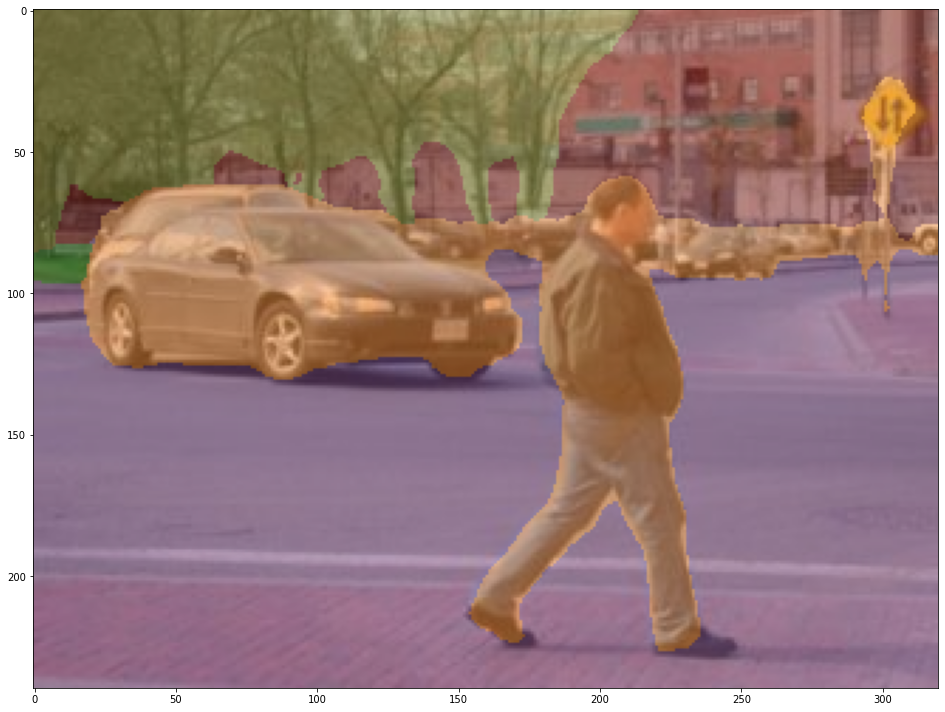

In [50]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
# from mmseg.core.evaluation import get_palette

img = mmcv.imread('data/stanford/iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)


<Figure size 576x432 with 0 Axes>

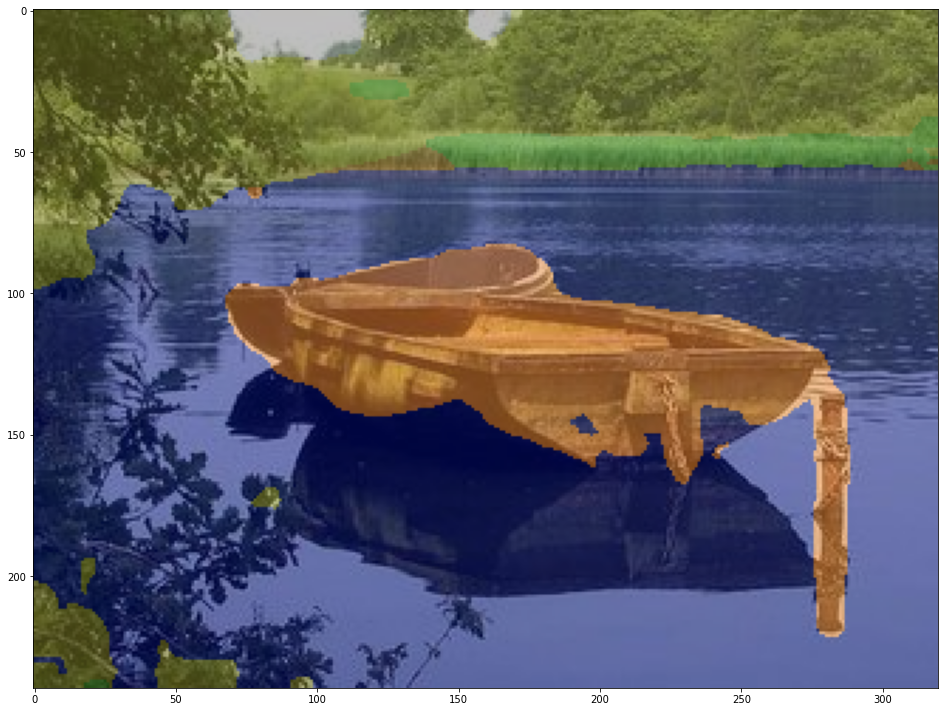

In [51]:

img = mmcv.imread('data/stanford/iccv09Data/images/2000032.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)


<Figure size 576x432 with 0 Axes>

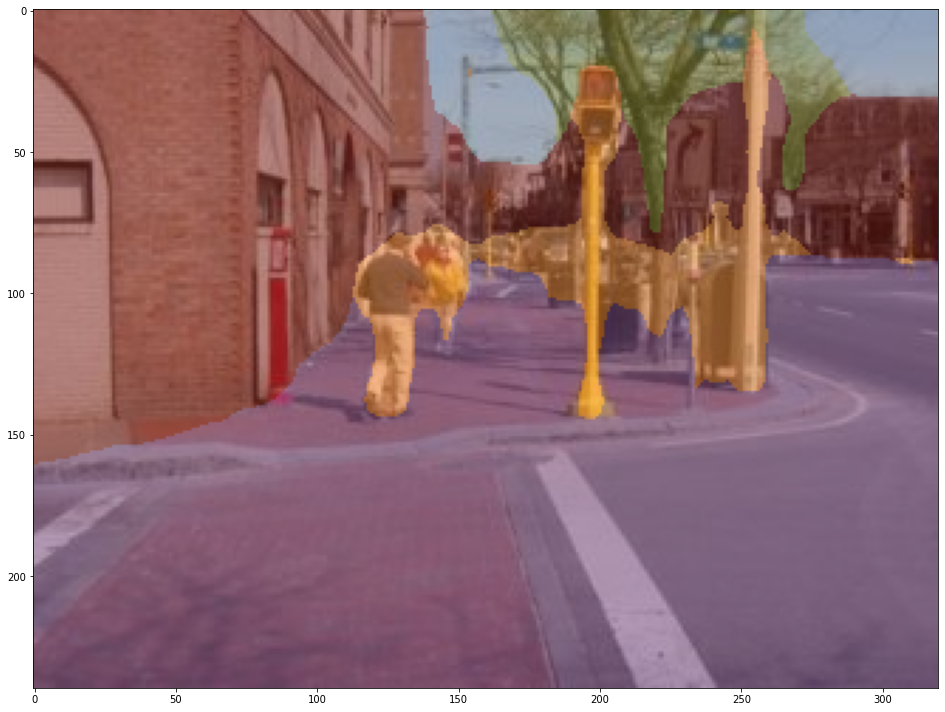

In [52]:

img = mmcv.imread('data/stanford/iccv09Data/images/6000132.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

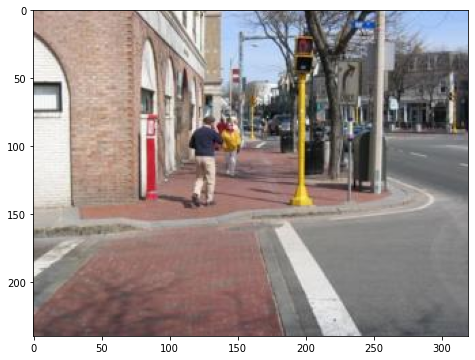

In [4]:
img = mmcv.imread('data/stanford/iccv09Data/images/6000132.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

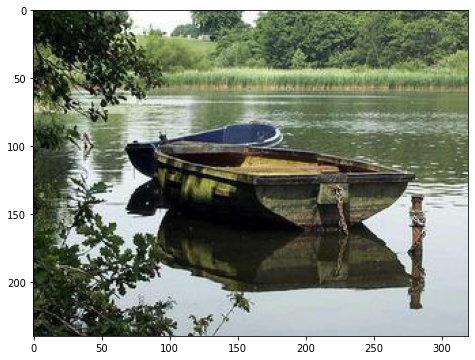

In [5]:
img = mmcv.imread('data/stanford/iccv09Data/images/2000032.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

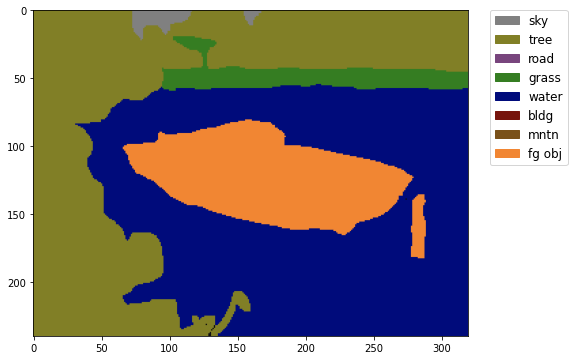

In [9]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('data/stanford/iccv09Data/labels/2000032.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

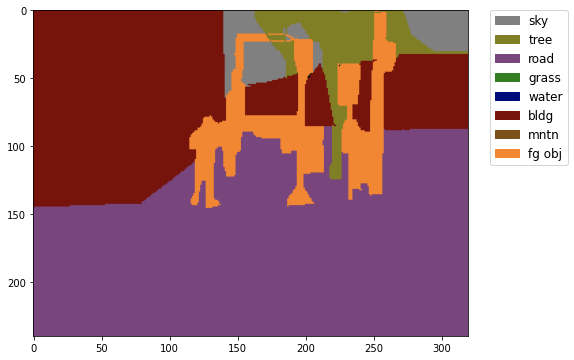

In [10]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('data/stanford/iccv09Data/labels/6000132.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()